## Compare detected face locations in different pliers face detection methods


### Tools that detect faces:

* Google Cloud Vision API
* Clarifai
* pliers itself


### Common measures
* boundaries of faces


### Ways to assess similarity
* Eucledian distance between coordinates?

In [9]:
import numpy as np
from os.path import join as opj
from pliers.extractors import (ClarifaiAPIImageExtractor,
                               FaceRecognitionFaceLocationsExtractor, 
                               GoogleVisionAPIFaceExtractor)
from pliers.stimuli import ImageStim

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as patches

In [75]:
def plot_boundingBox(img_pth, rect_coords, title):
    fig,ax = plt.subplots(1)
    plt_img = mpimg.imread(img_pth)
    imgplot = ax.imshow(plt_img)


    #bottom left xy, width, height
    rect = patches.Rectangle((rect_coords[0], rect_coords[1]), rect_coords[2], rect_coords[3],
                             linewidth=2,
                             edgecolor='r',
                             facecolor='none',
                            )

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.title(title)
    plt.show()

In [63]:
def extract_builtin(results,
                    api='builtin',
                    x=None,
                    y=None):
    """
    Extract bounding box coordinates from a face extraction with pliers build-in tool
    
    params
    ------
    results: pandas dataframe, result of a .to_df() operation on an extraction result
    api: one of 'builtin', 'clarifai', 'google'
    x, y: stimulus dimensions in pixel
    
    returns
    -------
    coords: dictionary, with one key per face and coordinates in pixel. Order of coords:
            top, right, bottom, left
            
    >>> extract_builtin(result_clarifai, api='clarifai', x=444, y=600)
    """
    
    allowed_api = ['builtin', 'clarifai', 'google']
    if api not in allowed_api:
        raise ValueError(f'expected api specification from on in {allowed_api}, however I got "{api}".')
    # initialize an exmpty dict
    coords = {}
    if api == 'builtin':
        for idx, i in results.iterrows():
            coords[idx] = [c for c in i['face_locations']]
            # simple assertion to check whether results are within image dimensions
            assert all([x_dim < x for x_dim in [coords[idx][1], coords[idx][3]]])
            assert all([y_dim < x for y_dim in [coords[idx][0], coords[idx][2]]])
    
    elif api == 'clarifai':
        assert x, y != None
        for idx, i in results.iterrows():
            # extract coordinates and scale them to pixels
            coords[idx] = [i['top_row'] * y,
                           i['right_col'] * x,
                           i['bottom_row'] * y,
                           i['left_col'] * x
                           ]
        
    return coords

In [20]:
# define static test images (single and many faces)
img_pth = opj('../', 'data', 'obama.jpg')
img_pth_many = opj('../', 'data', 'thai_people.jpg')
stim = ImageStim(img_pth)
stim_many = ImageStim(img_pth_many)


In [ ]:
# the results of the face detection are given relative to stimulus size. Let's get the image dimensions in pixel
y, x = stim.data.shape[:2]
print(f'the one-face picture is {x} pixel x {y} pixel in size')

y2, x2 = stim_many.data.shape[:2]
print(f'the many-face picture is {x2} pixel x {y2} pixel in size')

In [ ]:
# quick overview of the pictures
plt_img = mpimg.imread(img_pth)
plt_img2 = mpimg.imread(img_pth_many)
plt.figure(1)
plt.subplot(211)
plt.imshow(plt_img)

plt.subplot(212)
plt.imshow(plt_img2)

plt.show()


### pliers face detection

In [7]:
ext_pliers = FaceRecognitionFaceLocationsExtractor()
# for single face
result_pliers = ext_pliers.transform(stim).to_df()
# for many faces stimulus
result_pliers_many = ext_pliers.transform(stim_many).to_df()

In [8]:
# extract faces for single and multi-face images from pliers-builtin, and plot them
for res, im, x_dim, y_dim in [(result_pliers, img_pth, x, y), (result_pliers_many, img_pth_many, x2, y2)]:
    d = extract_builtin(res, x=x_dim, y=y_dim)
    for k, i in d.items():
        top, right, bottom, left = i
        box_width = right-left
        box_height = top-bottom
        coords = [left, bottom, box_width, box_height]
        plot_boundingBox(im, coords, 'Pliers builtin')

TypeError: '<' not supported between instances of 'int' and 'NoneType'

In [ ]:
# NOTE: THESE MAY BE INCORRECT
# transform css coordinates into pixel
# top_row = y - top
# bottom_row = y - bottom
# left_col = x - left
# right_col = x - right
# print(top_row, right_col, bottom_row, left_col)


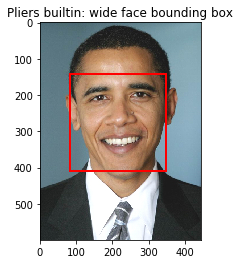

In [78]:
# Plot bounding on image 
box_width = right-left
box_height = top-bottom
coords = [left, bottom, box_width, box_height]
plot_boundingBox(img_pth, coords, 'Pliers builtin: wide face bounding box')



### clarifai face detection

In [67]:
# the clarifai extraction needs a model and an api key
model='face' 
ext_clarifai = ClarifaiAPIImageExtractor(api_key='d53d5755b7514b87877df990f2d0bbd4',
                                         model=model)
result_clarifai = ext_clarifai.transform(stim).to_df()


In [68]:
print(result_clarifai)

   order  duration  onset  object_id   top_row  left_col  bottom_row  \
0    NaN       NaN    NaN          0  0.118024  0.220802    0.717073   

   right_col  
0   0.788294  


In [69]:
# transform relative coordinates into pixel
top_row = y * result_clarifai['top_row'][0]
bottom_row = y * result_clarifai['bottom_row'][0]
left_col = x * result_clarifai['left_col'][0]
right_col = x * result_clarifai['right_col'][0]
print(top_row, right_col, bottom_row, left_col)

70.81428319215775 350.0025701522827 430.2435636520386 98.0360192656517


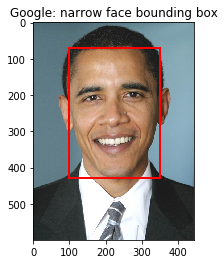

In [71]:
# Plot bounding on image 
box_width = right_col - left_col
box_height = top_row - bottom_row
coords = [left_col, bottom_row, box_width, box_height]
plot_boundingBox(img_pth, coords, 'Clarifai: wide face bounding box')

# fig,ax = plt.subplots(1)
# plt_img = mpimg.imread(img_pth)
# imgplot = ax.imshow(plt_img)


# #bottom left xy, width, height
# rect = patches.Rectangle((left_col,bottom_row),right_col-left_col,top_row-bottom_row,
#                          linewidth=2,
#                          edgecolor='r',
#                          facecolor='none',
#                         )

# #plt.scatter(0, top_row)

# # Add the patch to the Axes
# ax.add_patch(rect)
# plt.title('Pliers builtin: face bounding box')
# plt.show()

### Google Cloud vision API face detection

In [46]:
ext_google = GoogleVisionAPIFaceExtractor(discovery_file='/home/adina/NeuroHackademy-02c15db15c2a.json')
ext_google = GoogleVisionAPIFaceExtractor(discovery_file='/Users/Mai/NeuroHackademy-02c15db15c2a.json')
result_google = ext_google.transform(stim).to_df()

W0807 15:41:36.510330 140736167261056 google.py:52] [Errno 2] No such file or directory: '/home/adina/NeuroHackademy-02c15db15c2a.json'
W0807 15:41:36.520064 140736167261056 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client'

During handling of the above exception, another exception occurred:

Traceback (most recent call la

In [47]:
result_google

,order,duration,onset,object_id,boundingPoly_vertex1_x,boundingPoly_vertex1_y,boundingPoly_vertex2_x,boundingPoly_vertex2_y,boundingPoly_vertex3_x,boundingPoly_vertex3_y,...,tiltAngle,face_detectionConfidence,face_landmarkingConfidence,joyLikelihood,sorrowLikelihood,angerLikelihood,surpriseLikelihood,underExposedLikelihood,blurredLikelihood,headwearLikelihood
0,NaN,NaN,NaN,0,34,3,413,3,413,444,...,-2.058331,0.999946,0.84057,VERY_LIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY


In [64]:
# Google has "wide" and "narrow" bounding boxes. Here we get the wide bounding box

result_google.to_dict(orient='records')
# vertex coordinates are in the same scale as the original image.
# vertices are in order top-left, top-right, bottom-right, bottom-left.
top_left_x = result_google['boundingPoly_vertex1_x'][0]
top_right_x = result_google['boundingPoly_vertex2_x'][0]
bottom_right_x = result_google['boundingPoly_vertex3_x'][0]
bottom_left_x = result_google['boundingPoly_vertex4_x'][0]

top_left_y = result_google['boundingPoly_vertex1_y'][0]
top_right_y = result_google['boundingPoly_vertex2_y'][0]
bottom_right_y = result_google['boundingPoly_vertex3_y'][0]
bottom_left_y = result_google['boundingPoly_vertex4_y'][0]

print(top_left_x, top_right_x, bottom_right_x, bottom_left_x)
print(top_left_y, top_right_y, bottom_right_y, bottom_left_y)

34 413 413 34
3 3 444 444


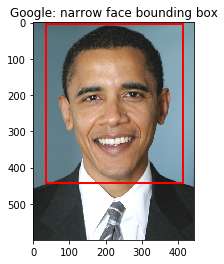

In [65]:
# # Plot bounding on image 
box_width = bottom_right_x - bottom_left_x
box_height = top_right_y - bottom_right_y
coords = [bottom_left_x, bottom_left_y, box_width, box_height]
plot_boundingBox(img_pth, coords, 'Google: wide face bounding box')

# fig,ax = plt.subplots(1)
# plt_img = mpimg.imread(img_pth)
# imgplot = ax.imshow(plt_img)


# #bottom left xy, width, height
# box_width = bottom_right_x - bottom_left_x
# box_height = top_right_y - bottom_right_y
# rect = patches.Rectangle((bottom_left_x,bottom_left_y), box_width, box_height,
#                          linewidth=2,
#                          edgecolor='r',
#                          facecolor='none',
#                         )

# # Add the patch to the Axes
# ax.add_patch(rect)
# plt.title('Google: wide face bounding box')
# plt.show()

In [62]:
# Google has "wide" and "narrow" bounding boxes. Here we get the narrow bounding box

result_google.to_dict(orient='records')
# vertex coordinates are in the same scale as the original image.
# vertices are in order top-left, top-right, bottom-right, bottom-left.
top_left_x = result_google['fdBoundingPoly_vertex1_x'][0]
top_right_x = result_google['fdBoundingPoly_vertex2_x'][0]
bottom_right_x = result_google['fdBoundingPoly_vertex3_x'][0]
bottom_left_x = result_google['fdBoundingPoly_vertex4_x'][0]

top_left_y = result_google['fdBoundingPoly_vertex1_y'][0]
top_right_y = result_google['fdBoundingPoly_vertex2_y'][0]
bottom_right_y = result_google['fdBoundingPoly_vertex3_y'][0]
bottom_left_y = result_google['fdBoundingPoly_vertex4_y'][0]

print(top_left_x, top_right_x, bottom_right_x, bottom_left_x)
print(top_left_y, top_right_y, bottom_right_y, bottom_left_y)


81 367 367 81
112 112 397 397


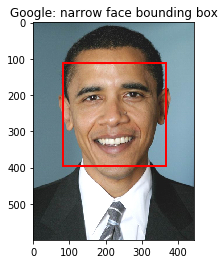

In [63]:

# Plot bounding on image 
coords = [bottom_left_x, bottom_left_y, bottom_right_x - bottom_left_x, top_right_y - bottom_right_y]
plot_boundingBox(img_pth, coords, 'Google: narrow face bounding box')
